<a href="https://colab.research.google.com/github/dmitriy-iliyov/data-science/blob/main/neural-network/xception/notebook/lab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

datasets_dir = '/content/drive/MyDrive/main/languages/Python/neural_network/labs/lab_6/data'
#'jp0909/car-logos', 'arnaud58/landscape-pictures',
paths = ['armaanoajay/flooded-images']

for path in paths:
  dir_name = path.split('/')[1]
  current_dir_path = os.path.join(datasets_dir, dir_name)

  os.makedirs(current_dir_path, exist_ok=True)

  !kaggle datasets download -d {path} -p {current_dir_path}

  zip_file_path = os.path.join(current_dir_path, f"{dir_name}.zip")
  !unzip -q {zip_file_path} -d {current_dir_path}

  os.remove(zip_file_path)



cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/armaanoajay/flooded-images
License(s): unknown
 86% 43.0M/49.9M [00:00<00:00, 149MB/s]
100% 49.9M/49.9M [00:00<00:00, 144MB/s]


In [ ]:
import os
import shutil
from pathlib import Path

datasets_dir = '/content/drive/MyDrive/main/languages/Python/neural_network/labs/lab_6/data'

def move_logs(logs_datasets_dir, result_data_set):
    count = 0
    for i in os.listdir(logs_datasets_dir):
        current_file_path = os.path.join(logs_datasets_dir, i)
        if os.path.isfile(current_file_path) and 'bmw' in i.lower():
            print(f'moving: {current_file_path}')
            target_path = os.path.join(result_data_set, 'cars')
            os.makedirs(target_path, exist_ok=True)

            shutil.move(current_file_path, target_path)
            count += 1
    print(f'Moved {count} images.')
    print(logs_datasets_dir)

def dir_processing(path, result_data_set):
    scenes_directory = Path(os.path.join(result_data_set, 'scenes'))
    scenes_directory.mkdir(parents=True, exist_ok=True)

    for i in os.listdir(path):
        current_path = os.path.join(path, i)
        if not os.path.isfile(current_path):
            dir_processing(current_path, result_data_set)
        else:
            dir_processing_part(current_path, result_data_set)

def dir_processing_part(file_path, result_data_set):
    target_path = os.path.join(result_data_set, 'scenes')
    target_file_path = os.path.join(target_path, os.path.basename(file_path))
    if os.path.exists(target_file_path):
        print(f"already exists: {target_file_path}")
        return
    try:
        shutil.move(file_path, target_path)
        print(f"moved: {file_path}")
    except Exception as e:
        print(f"error moving file {file_path}: {e}")

result_data_set = '/content/drive/MyDrive/main/languages/Python/neural_network/labs/lab_6/data/result_data_set'

logs_datasets_dir = os.path.join(datasets_dir, 'car-logos/images')

scenes_datasets_dir = os.path.join(datasets_dir, 'landscape-pictures')
dir_processing(scenes_datasets_dir, result_data_set)

scenes_datasets_dir = os.path.join(datasets_dir, 'flooded-images/auto_drones')
dir_processing(scenes_datasets_dir, result_data_set)

directory = Path(os.path.join(result_data_set, 'scenes'))
files = [f for f in directory.iterdir() if f.is_file()]
print(f"{len(files)} scenes images")


In [18]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator


def prepare_data(dataset_path):

    datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )


    return train_gen, val_gen


In [19]:
import time
import tensorflow as tf
import numpy as np
from keras import Model
from keras.src.applications.xception import Xception
from keras.src.callbacks import EarlyStopping
from keras.src.layers import GlobalAveragePooling2D, Dense
from keras.src.optimizers import Adam
from keras.src.saving import load_model
from matplotlib import pyplot as plt
from tensorflow_datasets.core.features.image_feature import cv2


class CustomizedXception:

    def __init__(self):
        self._model = None
        self._image_size = (299, 299)

    def init(self):
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        predictions = Dense(2, activation='softmax')(x)

        self._model = Model(inputs=base_model.input, outputs=predictions)
        for layer in base_model.layers:
            layer.trainable = False

        self._model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    def summary(self):
        self._model.summary()

    def fit(self, train_gen, validation_gen, epochs=100, batch_size=32):
        start_time = time.time()

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=1,
            restore_best_weights=True
        )

        history = self._model.fit(
            train_gen,
            epochs=epochs,
            validation_data=validation_gen,
            validation_steps=validation_gen.samples // batch_size,
            callbacks=[early_stopping]
        )

        execution_time = time.time() - start_time
        print(f"Training completed in {execution_time:.2f} seconds.")

        self.plot_history(history, execution_time)
        self.save()

        return history, execution_time


    def evaluate(self, test_data, test_answers):
        test_loss, test_accuracy = self._model.evaluate(test_data, test_answers, verbose=1)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
        return test_loss, test_accuracy

    def predict(self, sequence):
        return self._model.predict(sequence)

    def save(self, path='/content/drive/MyDrive/main/languages/Python/neural_network/labs/lab_6/model/xception_model.keras'):
        self._model.save(path)

    def load_model(self, path='/model_files/xception_model.keras'):
        self._model = load_model(path)
        print('sucseccfuly saved')

    def analyze_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frame_rate = cap.get(cv2.CAP_PROP_FPS)

        frame_count = 0
        timestamps = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            if frame_count % int(frame_rate) == 0:
                resized_frame = cv2.resize(frame, self._image_size)
                img_array = np.expand_dims(resized_frame / 255.0, axis=0)
                prediction = self._model.predict(img_array)[0]

                if np.argmax(prediction) == 0:
                    timestamps.append(frame_count / frame_rate)

        cap.release()
        return timestamps

    @staticmethod
    def plot_history(history, execution_time):
        epochs = len(history.history['loss'])
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy (Execution Time: {execution_time:.2f} seconds)')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(range(1, epochs + 1), history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()



Found 7502 images belonging to 2 classes.
Found 1875 images belonging to 2 classes.
{'logo': 0, 'scenes': 1}
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 4155s 18s/step - accuracy: 0.9877 - loss: 0.0540 - val_accuracy: 0.9989 - val_loss: 0.0018
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3304s 14s/step - accuracy: 1.0000 - loss: 8.2463e-04 - val_accuracy: 1.0000 - val_loss: 1.4912e-05
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


235/235 ━━━━━━━━━━━━━━━━━━━━ 4126s 18s/step - accuracy: 1.0000 - loss: 4.9016e-04 - val_accuracy: 0.9984 - val_loss: 0.0071
Training completed in 11591.33 seconds.


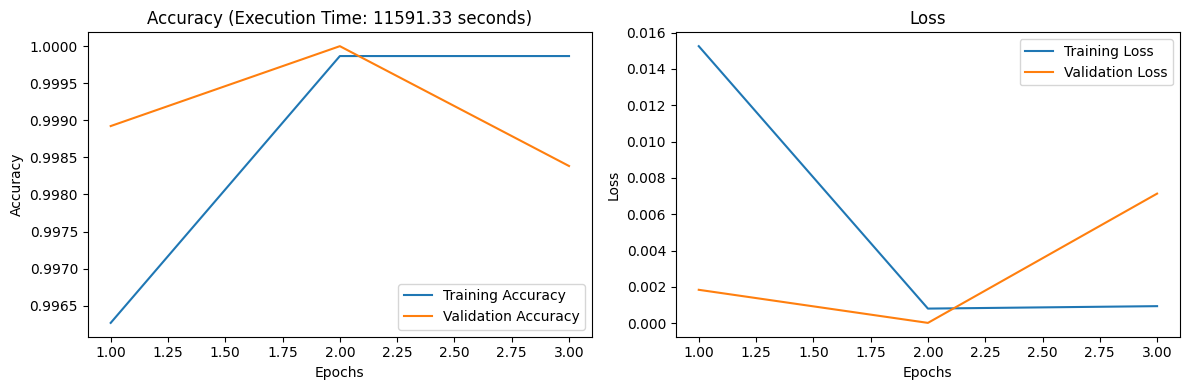

In [20]:
train_gen, val_gen = prepare_data(result_data_set)
print(train_gen.class_indices)
with tf.device('/GPU:0'):
  xception_model = CustomizedXception()
  xception_model.init()
  xception_model.fit(train_gen, val_gen)